In [1]:

import pandas as pd

import numpy as np

from datetime import datetime, timedelta



# Generate mock sales data

np.random.seed(42)

start_date = datetime(2020, 1, 1)

num_months = 48 # 4 years of monthly data

date_rng = pd.date_range(start_date, periods=num_months, freq='MS') # MS for Month Start



sales_data = pd.DataFrame(date_rng, columns=['Date'])



# Base sales with a slight upward trend

base_sales = 10000 + np.arange(num_months) * 50



# Seasonal component (higher in Q4, lower in Q1)

seasonal_component = 2000 * np.sin(2 * np.pi * (sales_data['Date'].dt.month - 1) / 12 + np.pi/2) \
    + 1500 * np.sin(2 * np.pi * (sales_data['Date'].dt.month - 1) / 6)



# Random noise

noise = np.random.normal(0, 500, num_months)



sales_data['SalesAmount'] = (base_sales + seasonal_component + noise).astype(int)

sales_data['SalesAmount'] = sales_data['SalesAmount'].clip(lower=2000) # Ensure sales are positive



# Add promotional flags (randomly)

sales_data['Promotion'] = np.random.choice([0, 1], num_months, p=[0.8, 0.2])

sales_data.loc[sales_data['Promotion'] == 1, 'SalesAmount'] *= np.random.uniform(1.1, 1.3) # Increase sales during promotion



# Add holiday flags (e.g., December)

sales_data['HolidayMonth'] = (sales_data['Date'].dt.month == 12).astype(int)

sales_data.loc[sales_data['HolidayMonth'] == 1, 'SalesAmount'] *= np.random.uniform(1.15, 1.4) # Increase sales during holiday month



sales_data['SalesAmount'] = sales_data['SalesAmount'].astype(int)



# Save to CSV

sales_data.to_csv('retail_sales_mock_data.csv', index=False)

print("Mock retail sales data generated: retail_sales_mock_data.csv")

print(sales_data.head())



Mock retail sales data generated: retail_sales_mock_data.csv
        Date  SalesAmount  Promotion  HolidayMonth
0 2020-01-01        12248          0             0
1 2020-02-01        13011          0             0
2 2020-03-01        12722          0             0
3 2020-04-01        14030          1             0
4 2020-05-01         7783          0             0


C:\Users\Raaid Yousuf\AppData\Local\Temp\ipykernel_6980\976598628.py:54: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[14030.88621694  9131.45660586 13786.55770615 10279.80060657
 16623.34031037 12949.41107182]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  sales_data.loc[sales_data['Promotion'] == 1, 'SalesAmount'] *= np.random.uniform(1.1, 1.3) # Increase sales during promotion


# Data Exploration and Preparation

In [2]:
# Load the dataset
sales_data = pd.read_csv("retail_sales_mock_data.csv")

# Convert Date column to datetime
sales_data['Date'] = pd.to_datetime(sales_data['Date'])

# Set Date as index
sales_data.set_index('Date', inplace=True)



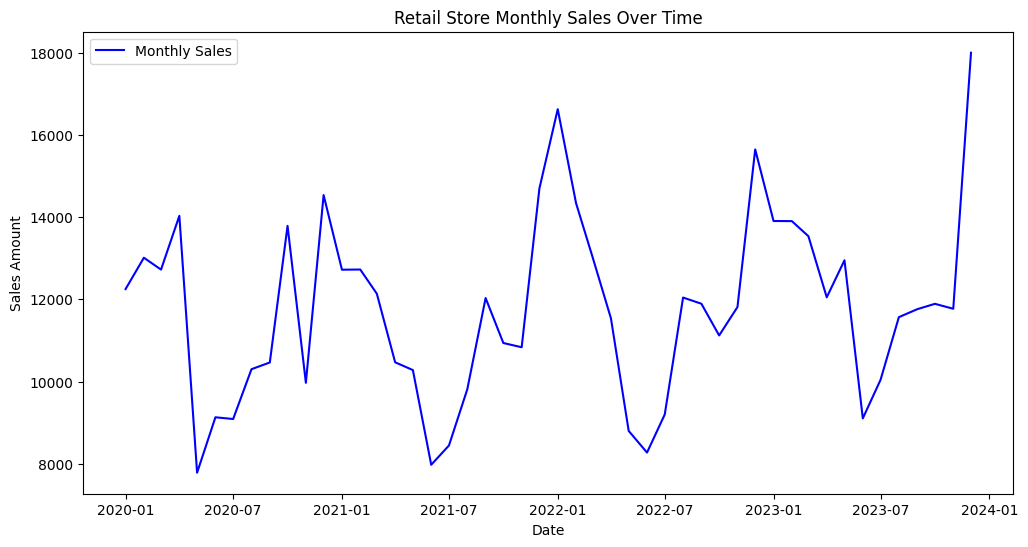

In [3]:
# Import libraries
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# --- 1. Sales over time ---
plt.figure(figsize=(12,6))
plt.plot(sales_data.index, sales_data['SalesAmount'], label="Monthly Sales", color="blue")
plt.title("Retail Store Monthly Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales Amount")
plt.legend()
plt.show()



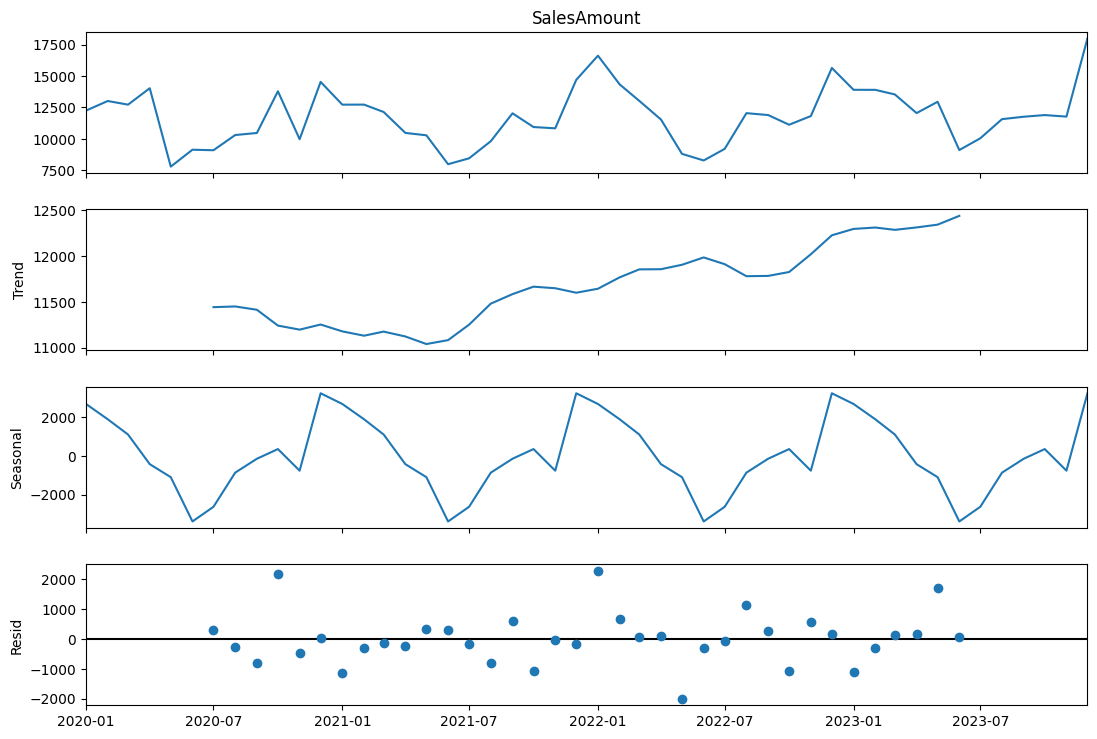

In [4]:
# --- 2. Decomposition ---
decomposition = seasonal_decompose(sales_data['SalesAmount'], model='additive', period=12)

fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.show()

In [5]:
# --- 3. Stationarity Check (ADF Test) ---
adf_result = adfuller(sales_data['SalesAmount'])
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
for key, value in adf_result[4].items():
    print('Critical Value (%s): %.3f' % (key, value))

if adf_result[1] <= 0.05:
    print("\n✅ The series is stationary (reject H0).")
else:
    print("\n⚠️ The series is NOT stationary (fail to reject H0). Differencing may be needed.")



ADF Statistic: -4.5141835977339575
p-value: 0.00018535586430261453
Critical Value (1%): -3.597
Critical Value (5%): -2.933
Critical Value (10%): -2.605

✅ The series is stationary (reject H0).


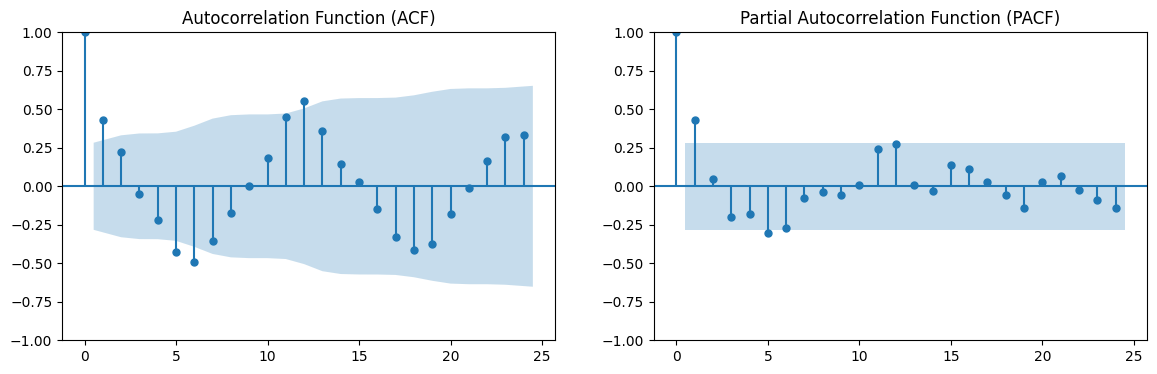

In [6]:
# --- 4. ACF & PACF plots ---
fig, axes = plt.subplots(1, 2, figsize=(14,4))

plot_acf(sales_data['SalesAmount'], lags=24, ax=axes[0])
axes[0].set_title("Autocorrelation Function (ACF)")

plot_pacf(sales_data['SalesAmount'], lags=24, ax=axes[1])
axes[1].set_title("Partial Autocorrelation Function (PACF)")

plt.show()


In [7]:
# --- Check for missing values ---
print("Missing values per column:\n")
print(sales_data.isnull().sum())


Missing values per column:

SalesAmount     0
Promotion       0
HolidayMonth    0
dtype: int64


# Feature Engineering

In [8]:
# Assume sales_data already has ['SalesAmount', 'Promotion', 'HolidayMonth']

# --- 1. Promotion Features ---
# Promotion flag is already binary (0/1)
# Let's add interaction with month (some months might respond stronger to promotions)
sales_data['Promo_Effect'] = sales_data['Promotion'] * sales_data['SalesAmount'].shift(1).fillna(method='bfill')

# Rolling average effect of promotions (how promotions worked in the last 3 months)
sales_data['Promo_Rolling'] = (sales_data['Promotion'] * sales_data['SalesAmount']).rolling(window=3).mean()

# --- 2. Holiday Features ---
# HolidayMonth is already 0/1 for December
# Create a "post-holiday lag" effect (sales drop in Jan after Dec holidays)
sales_data['PostHoliday'] = sales_data['HolidayMonth'].shift(1).fillna(0)

# --- 3. Date-based Seasonal Features ---
sales_data['Month'] = sales_data.index.month
sales_data['Quarter'] = sales_data.index.quarter
sales_data['Year'] = sales_data.index.year

# Encode cyclical month feature (important for ML models, not for SARIMA/Prophet)
sales_data['Month_sin'] = np.sin(2 * np.pi * sales_data['Month']/12)
sales_data['Month_cos'] = np.cos(2 * np.pi * sales_data['Month']/12)

print(sales_data.head(15))


C:\Users\Raaid Yousuf\AppData\Local\Temp\ipykernel_6980\3360964209.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sales_data['Promo_Effect'] = sales_data['Promotion'] * sales_data['SalesAmount'].shift(1).fillna(method='bfill')


            SalesAmount  Promotion  HolidayMonth  Promo_Effect  Promo_Rolling  \
Date                                                                            
2020-01-01        12248          0             0           0.0            NaN   
2020-02-01        13011          0             0           0.0            NaN   
2020-03-01        12722          0             0           0.0       0.000000   
2020-04-01        14030          1             0       12722.0    4676.666667   
2020-05-01         7783          0             0           0.0    4676.666667   
2020-06-01         9131          1             0        7783.0    7720.333333   
2020-07-01         9089          0             0           0.0    3043.666667   
2020-08-01        10300          0             0           0.0    3043.666667   
2020-09-01        10464          0             0           0.0       0.000000   
2020-10-01        13786          1             0       10464.0    4595.333333   
2020-11-01         9969     

In [9]:
sales_data.head()

,SalesAmount,Promotion,HolidayMonth,Promo_Effect,Promo_Rolling,PostHoliday,Month,Quarter,Year,Month_sin,Month_cos
Date,,,,,,,,,,,
2020-01-01,12248,0,0,0.0,NaN,0.0,1,1,2020,0.500000,8.660254e-01
2020-02-01,13011,0,0,0.0,NaN,0.0,2,1,2020,0.866025,5.000000e-01
2020-03-01,12722,0,0,0.0,0.000000,0.0,3,1,2020,1.000000,6.123234e-17
2020-04-01,14030,1,0,12722.0,4676.666667,0.0,4,2,2020,0.866025,-5.000000e-01
2020-05-01,7783,0,0,0.0,4676.666667,0.0,5,2,2020,0.500000,-8.660254e-01


# Model selection and training

Training range   : 2020-01-01 → 2023-02-01
Validation range : 2023-03-01 → 2023-12-01


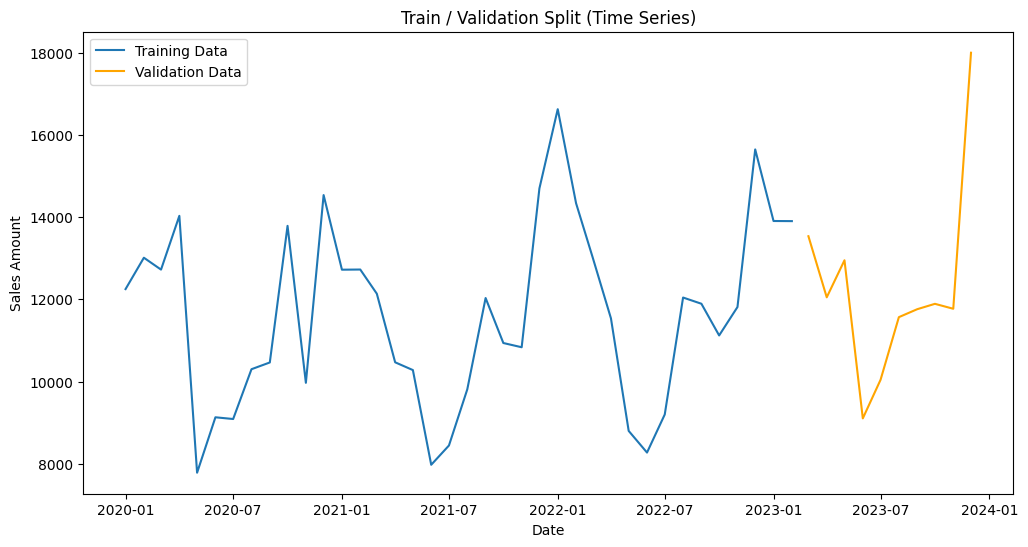

In [10]:
import matplotlib.pyplot as plt

# Target (sales)
y = sales_data['SalesAmount']

# Optional regressors (for SARIMAX / Prophet)
X = sales_data[['Promotion', 'HolidayMonth']]

# --- Split index ---
train_size = int(len(y) * 0.8)  # 80% train, 20% validation

# Training set
y_train, y_valid = y.iloc[:train_size], y.iloc[train_size:]
X_train, X_valid = X.iloc[:train_size], X.iloc[train_size:]

print("Training range   :", y_train.index.min().date(), "→", y_train.index.max().date())
print("Validation range :", y_valid.index.min().date(), "→", y_valid.index.max().date())

# --- Visualization ---
plt.figure(figsize=(12,6))
plt.plot(y_train.index, y_train, label="Training Data")
plt.plot(y_valid.index, y_valid, label="Validation Data", color="orange")
plt.title("Train / Validation Split (Time Series)")
plt.xlabel("Date")
plt.ylabel("Sales Amount")
plt.legend()
plt.show()


In [11]:
# Arima Model
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# --- Train ARIMA ---
arima_model = ARIMA(y_train, order=(1,1,1))  # (p,d,q)
arima_result = arima_model.fit()

# Forecast for validation period
arima_forecast = arima_result.forecast(steps=len(y_valid))

# Evaluate
arima_mae = mean_absolute_error(y_valid, arima_forecast)
arima_rmse = np.sqrt(mean_squared_error(y_valid, arima_forecast))

print("ARIMA MAE:", arima_mae)
print("ARIMA RMSE:", arima_rmse)


c:\Users\Raaid Yousuf\.conda\envs\ml_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Raaid Yousuf\.conda\envs\ml_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Raaid Yousuf\.conda\envs\ml_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA MAE: 2427.4001688616154
ARIMA RMSE: 2769.819703750192


In [12]:
# Sarima Model
from statsmodels.tsa.statespace.sarimax import SARIMAX

# --- Train SARIMA ---
sarima_model = SARIMAX(y_train, order=(1,1,1), seasonal_order=(1,1,1,12))
sarima_result = sarima_model.fit(disp=False)

# Forecast
sarima_forecast = sarima_result.forecast(steps=len(y_valid))

# Evaluate
sarima_mae = mean_absolute_error(y_valid, sarima_forecast)
sarima_rmse = np.sqrt(mean_squared_error(y_valid, sarima_forecast))

print("SARIMA MAE:", sarima_mae)
print("SARIMA RMSE:", sarima_rmse)


c:\Users\Raaid Yousuf\.conda\envs\ml_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Raaid Yousuf\.conda\envs\ml_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Raaid Yousuf\.conda\envs\ml_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA MAE: 1193.9728033007227
SARIMA RMSE: 1534.4296126886825


In [13]:
# Expnential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# --- Train Exponential Smoothing ---
hw_model = ExponentialSmoothing(
    y_train, 
    trend="add",        # can also try "mul"
    seasonal="add",     # can also try "mul"
    seasonal_periods=12 # yearly seasonality (monthly data)
)
hw_result = hw_model.fit()

# Forecast
hw_forecast = hw_result.forecast(steps=len(y_valid))

# Evaluate
hw_mae = mean_absolute_error(y_valid, hw_forecast)
hw_rmse = np.sqrt(mean_squared_error(y_valid, hw_forecast))

print("HW MAE:", hw_mae)
print("HW RMSE:", hw_rmse)


c:\Users\Raaid Yousuf\.conda\envs\ml_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


HW MAE: 1046.9621728920863
HW RMSE: 1383.1908965147886


c:\Users\Raaid Yousuf\.conda\envs\ml_env\lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


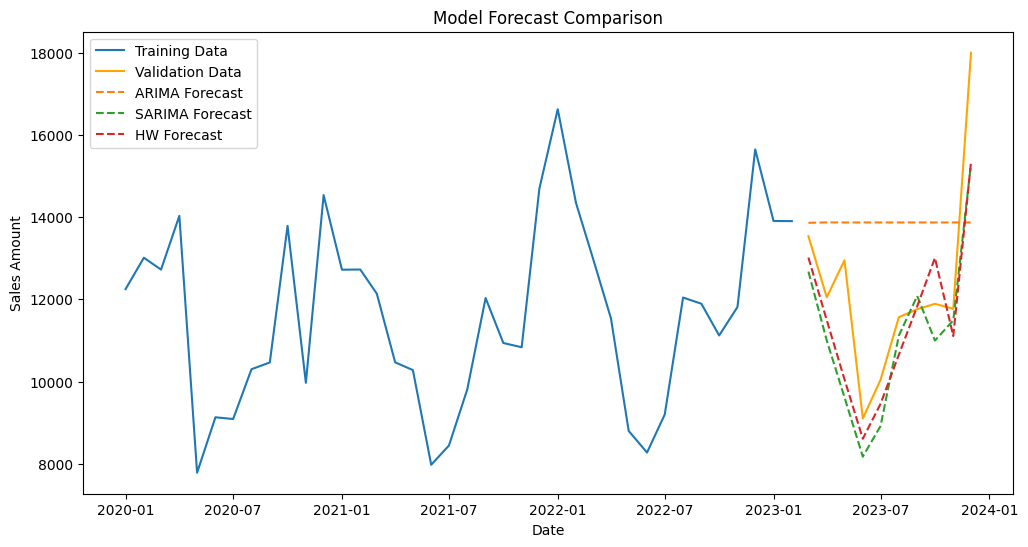

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(y_train.index, y_train, label="Training Data")
plt.plot(y_valid.index, y_valid, label="Validation Data", color="orange")
plt.plot(y_valid.index, arima_forecast, label="ARIMA Forecast", linestyle="--")
plt.plot(y_valid.index, sarima_forecast, label="SARIMA Forecast", linestyle="--")
plt.plot(y_valid.index, hw_forecast, label="HW Forecast", linestyle="--")
plt.title("Model Forecast Comparison")
plt.xlabel("Date")
plt.ylabel("Sales Amount")
plt.legend()
plt.show()


In [15]:
!pip install pmdarima -q
from pmdarima import auto_arima

# Use auto_arima on training data
stepwise_model = auto_arima(
    y_train,
    exogenous=None,            # if using SARIMAX, pass X_train here
    seasonal=True,             # enable for SARIMA
    m=12,                      # seasonality period (12 months)
    trace=True,                # prints trial results
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

print(stepwise_model.summary())

# Fit final SARIMA model with best parameters
sarima_best = SARIMAX(
    y_train,
    order=stepwise_model.order,
    seasonal_order=stepwise_model.seasonal_order
).fit()

# Forecast validation period
sarima_forecast_best = sarima_best.forecast(steps=len(y_valid))

# Evaluate
sarima_mae_best = mean_absolute_error(y_valid, sarima_forecast_best)
sarima_rmse_best = np.sqrt(mean_squared_error(y_valid, sarima_forecast_best))

print("Tuned SARIMA MAE:", sarima_mae_best)
print("Tuned SARIMA RMSE:", sarima_rmse_best)


c:\Users\Raaid Yousuf\.conda\envs\ml_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Raaid Yousuf\.conda\envs\ml_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Raaid Yousuf\.conda\envs\ml_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Raaid Yousuf\.conda\envs\ml_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Raaid Yousuf\.conda\envs\ml_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'e

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=5.36 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=462.494, Time=0.04 sec


c:\Users\Raaid Yousuf\.conda\envs\ml_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Raaid Yousuf\.conda\envs\ml_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=463.355, Time=0.56 sec


c:\Users\Raaid Yousuf\.conda\envs\ml_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=463.218, Time=0.83 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=460.734, Time=0.05 sec


c:\Users\Raaid Yousuf\.conda\envs\ml_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Raaid Yousuf\.conda\envs\ml_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=458.808, Time=1.89 sec


c:\Users\Raaid Yousuf\.conda\envs\ml_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=460.647, Time=0.51 sec


c:\Users\Raaid Yousuf\.conda\envs\ml_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.67 sec


c:\Users\Raaid Yousuf\.conda\envs\ml_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=461.831, Time=0.31 sec


c:\Users\Raaid Yousuf\.conda\envs\ml_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.88 sec


c:\Users\Raaid Yousuf\.conda\envs\ml_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=462.771, Time=0.20 sec


c:\Users\Raaid Yousuf\.conda\envs\ml_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=461.324, Time=3.22 sec
 ARIMA(0,0,0)(1,1,0)[12]             : AIC=460.933, Time=0.20 sec

Best model:  ARIMA(0,0,0)(1,1,0)[12] intercept
Total fit time: 18.880 seconds


c:\Users\Raaid Yousuf\.conda\envs\ml_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                SARIMAX Results                                 
Dep. Variable:                        y   No. Observations:                   38
Model:             SARIMAX(1, 1, 0, 12)   Log Likelihood                -226.404
Date:                  Tue, 09 Sep 2025   AIC                            458.808
Time:                          19:43:57   BIC                            462.582
Sample:                      01-01-2020   HQIC                           459.894
                           - 02-01-2023                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    634.7116    472.758      1.343      0.179    -291.877    1561.300
ar.S.L12      -0.1609      0.087     -1.840      0.066      -0.332       0.011
sigma2      1.844e+06   5.53e+05    

c:\Users\Raaid Yousuf\.conda\envs\ml_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Raaid Yousuf\.conda\envs\ml_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Tuned SARIMA MAE: 1066.209898223774
Tuned SARIMA RMSE: 1583.932194482073


# Model Evaluation and Forecasting

In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# --- Evaluation function ---
def evaluate_forecast(y_true, y_pred, model_name="Model"):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    print(f"\n📊 {model_name} Performance:")
    print(f"MAE  : {mae:.2f}")
    print(f"MSE  : {mse:.2f}")
    print(f"RMSE : {rmse:.2f}")
    print(f"MAPE : {mape:.2f}%")
    
    return {"MAE": mae, "MSE": mse, "RMSE": rmse, "MAPE": mape}


In [17]:
# Evaluate ARIMA
arima_metrics = evaluate_forecast(y_valid, arima_forecast, "ARIMA")

# Evaluate SARIMA
sarima_metrics = evaluate_forecast(y_valid, sarima_forecast, "SARIMA")

# Evaluate Exponential Smoothing (Holt-Winters)
hw_metrics = evaluate_forecast(y_valid, hw_forecast, "Exponential Smoothing")



📊 ARIMA Performance:
MAE  : 2427.40
MSE  : 7671901.19
RMSE : 2769.82
MAPE : 21.03%

📊 SARIMA Performance:
MAE  : 1193.97
MSE  : 2354474.24
RMSE : 1534.43
MAPE : 9.37%

📊 Exponential Smoothing Performance:
MAE  : 1046.96
MSE  : 1913217.06
RMSE : 1383.19
MAPE : 8.03%


In [18]:
# selecting the best model
import pandas as pd

# Example results (replace with your actual metrics from evaluation step)
results_df = pd.DataFrame([
    arima_metrics,
    sarima_metrics,
    hw_metrics
])

print("\n📊 Model Comparison:\n")
print(results_df)



📊 Model Comparison:

           MAE           MSE         RMSE       MAPE
0  2427.400169  7.671901e+06  2769.819704  21.031545
1  1193.972803  2.354474e+06  1534.429613   9.371828
2  1046.962173  1.913217e+06  1383.190897   8.034093


In [30]:
# Reset index so model names become a column
results_df = results_df.reset_index().rename(columns={"index": "Model"})

# Now pick the best
best_row = results_df.loc[results_df["RMSE"].idxmin()]
best_model_name = best_row["Model"]

print(f"\n✅ Best model based on RMSE: {best_model_name}")



✅ Best model based on RMSE: Model    2.0
Model    2.0
Model    2.0
Model    2.0
Model    2.0
Name: 2, dtype: float64


In [23]:
# Retrain based on which model was best
if "SARIMA" in best_model_name:
    final_model = SARIMAX(
        y, 
        order=stepwise_model.order,
        seasonal_order=stepwise_model.seasonal_order
    ).fit()

elif "ARIMA" in best_model_name:
    final_model = ARIMA(
        y, 
        order=arima_stepwise.order
    ).fit()

elif "Exponential Smoothing" in best_model_name:
    final_model = ExponentialSmoothing(
        y, 
        trend="mul", 
        seasonal="mul", 
        seasonal_periods=12
    ).fit()


In [27]:
final_model = ExponentialSmoothing(
    y,
    trend="mul", 
    seasonal="mul", 
    seasonal_periods=12
).fit()


c:\Users\Raaid Yousuf\.conda\envs\ml_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Raaid Yousuf\.conda\envs\ml_env\lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [31]:
import numpy as np
import pandas as pd

# Forecast horizon
n_forecast = 6

# Generate point forecasts
forecast_mean = final_model.forecast(steps=n_forecast)

# --- Approximate confidence intervals (since Holt-Winters has none built-in) ---
# Calculate residuals
resid = y - final_model.fittedvalues
resid_std = np.std(resid)

# 95% confidence interval approximation
lower_ci = forecast_mean - 1.96 * resid_std
upper_ci = forecast_mean + 1.96 * resid_std

# Create future dates
future_dates = pd.date_range(
    y.index[-1] + pd.DateOffset(months=1),
    periods=n_forecast,
    freq="MS"
)

# Build forecast DataFrame
forecast_df = pd.DataFrame({
    "Date": future_dates,
    "Forecast": forecast_mean.values,
    "Lower_CI": lower_ci.values,
    "Upper_CI": upper_ci.values
})

print("\n📈 6-Month Forecast with Approximate Confidence Intervals:")
print(forecast_df)



📈 6-Month Forecast with Approximate Confidence Intervals:
        Date      Forecast      Lower_CI      Upper_CI
0 2024-01-01  15966.661844  13778.549634  18154.774054
1 2024-02-01  15165.608730  12977.496520  17353.720940
2 2024-03-01  14360.769795  12172.657585  16548.882005
3 2024-04-01  12716.090819  10527.978609  14904.203029
4 2024-05-01  12023.306448   9835.194238  14211.418658
5 2024-06-01   9525.578018   7337.465808  11713.690228


# Reporting

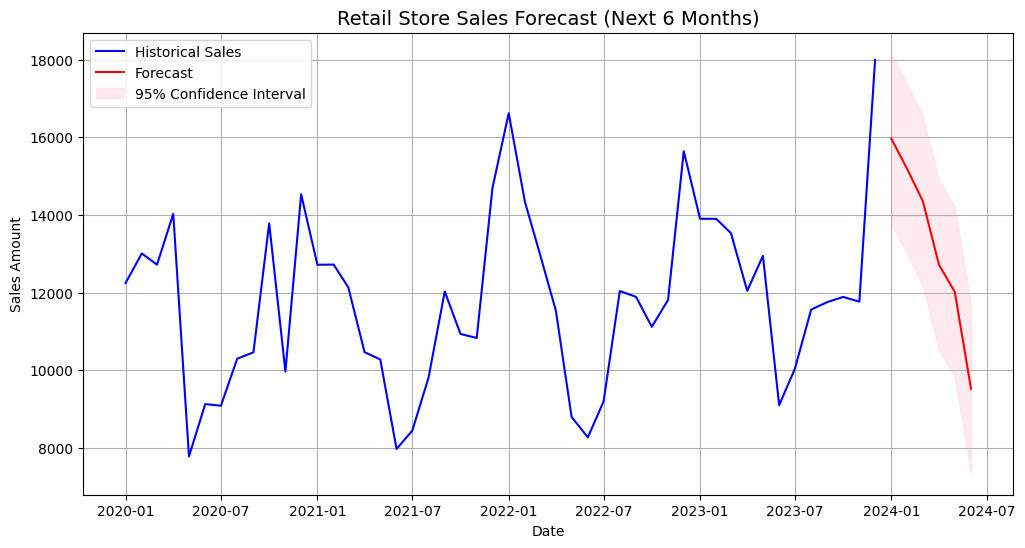

In [32]:
import matplotlib.pyplot as plt

# Plot historical data
plt.figure(figsize=(12,6))
plt.plot(y.index, y, label="Historical Sales", color="blue")

# Plot forecast
plt.plot(forecast_df["Date"], forecast_df["Forecast"], label="Forecast", color="red")

# Plot confidence intervals (shaded area)
plt.fill_between(
    forecast_df["Date"],
    forecast_df["Lower_CI"],
    forecast_df["Upper_CI"],
    color="pink", alpha=0.3, label="95% Confidence Interval"
)

# Labels & Title
plt.title("Retail Store Sales Forecast (Next 6 Months)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Sales Amount")
plt.legend()
plt.grid(True)
plt.show()


In [33]:
# Save final forecast data to CSV
forecast_df.to_csv("final_sales_forecast.csv", index=False)

print("✅ Forecast data saved as final_sales_forecast.csv")


✅ Forecast data saved as final_sales_forecast.csv
